# Lecture : Weisfeiler-Lehman GNNs

## Lab 01 : GIN -- Solution

### Xavier Bresson

Xu, Hu, Leskovec, Jegelka, How powerful are graph neural networks, 2018   
https://arxiv.org/pdf/1810.00826.pdf


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML_May23_codes/codes/06_WL_GNN'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    

In [2]:
# Libraries
import dgl
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut
import time


# Generate CSL dataset

[Graph(num_nodes=7, num_edges=28,
      ndata_schemes={}
      edata_schemes={}), tensor(0)]


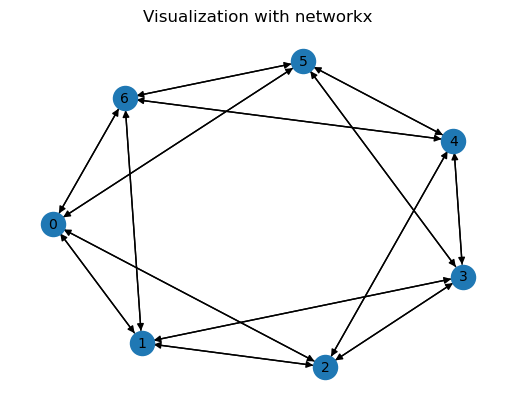

In [3]:
def generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class):
    label_class = 0
    list_graph = []
    # loop over skip values
    for skip_value in list_skip_value:
        # build CSL graph with node indexing in {0,1,...,num_nodes-1}
        list_src = []
        list_dst = []
        for i in range(num_nodes):
            # cycle
            list_src.append(i)
            list_dst.append((i+1)%num_nodes)
            # skip connection
            list_src.append(i)
            list_dst.append((i+skip_value)%num_nodes)
        graph = dgl.graph((list_src, list_dst)) # Build DGL graph
        graph = dgl.to_bidirected(graph) # symmetrize/undirected graph
        list_graph.append([graph, torch.tensor(label_class).long()])
        for _ in range(num_graph_per_class-1): # build CSL graph with random node indexing
            idx_shuffle = torch.randperm(num_nodes).tolist() # random permutation of node indexing
            list_src = [idx_shuffle[i] for i in list_src]
            list_dst = [idx_shuffle[i] for i in list_dst]
            graph = dgl.graph((list_src, list_dst)) # Build DGL graph
            graph = dgl.to_bidirected(graph) # symmetrize/undirected graph
            list_graph.append([graph, torch.tensor(label_class).long()])
        # increment class label
        label_class += 1
    return list_graph


# Generate small CSL graph
num_nodes = 7; list_skip_value = [2]; num_graph_per_class = 1
small_csl_graph = generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class)
print(small_csl_graph[0])
graph = small_csl_graph[0][0]
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw(graph.to_networkx(), ax=ax, with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()


# Generate train and test datasets 

## Add node feature

In [4]:
# Laplacian eigenvectors as positional encoding
def LapEig_positional_encoding(g, pos_enc_dim):
    Adj = g.adj().to_dense() # Adjacency matrix
    Dn = ( g.in_degrees()** -0.5 ).diag() # Inverse and sqrt of degree matrix
    Lap = torch.eye(g.number_of_nodes()) - Dn.matmul(Adj).matmul(Dn) # Laplacian operator
    EigVal, EigVec = torch.linalg.eig(Lap) # Compute full EVD
    EigVal, EigVec = EigVal.real, EigVec.real # make eig real
    EigVec = EigVec[:, EigVal.argsort()] # sort in increasing order of eigenvalues
    EigVec = EigVec[:,1:pos_enc_dim+1] # select the first non-trivial "pos_enc_dim" eigenvector
    return EigVec

# Add node and edge features to graphs
pos_enc_dim = 6 # dimension of PE
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['degree'] = graph.in_degrees().view(-1, 1).float() # node degree as node feature
        graph.ndata['random'] = torch.rand((graph.number_of_nodes(), pos_enc_dim)) # random features
        graph.ndata['index'] = torch.arange(graph.number_of_nodes()) # node index as node feature
        graph.ndata['pos_enc'] = LapEig_positional_encoding(graph, pos_enc_dim) # node positional encoding as node feature 
    return dataset

# Generate CSL datasets
num_nodes = 41
list_skip_value = [2, 3, 4, 5, 6, 9, 11, 12, 13, 16]
num_graph_per_class = 15
trainset = generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class)
testset = generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class)
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
print(trainset[0])


[Graph(num_nodes=41, num_edges=164,
      ndata_schemes={'degree': Scheme(shape=(1,), dtype=torch.float32), 'random': Scheme(shape=(6,), dtype=torch.float32), 'index': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={}), tensor(0)]


# Visualize positional encoding

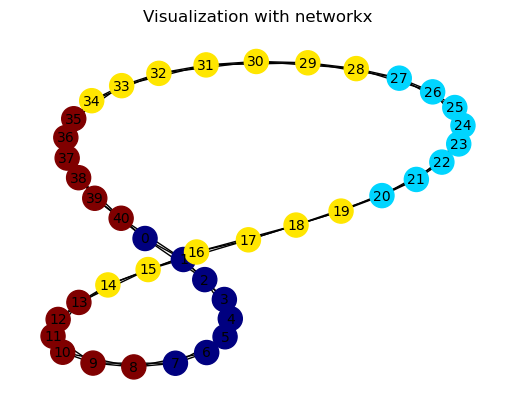

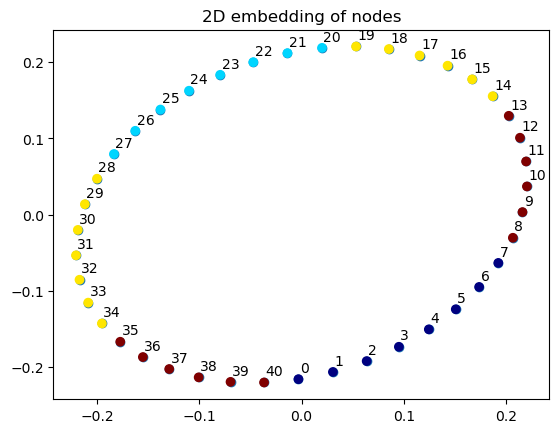

In [5]:
graph = trainset[0][0]

# Visualize graph
fig = plt.figure()
ax = fig.add_subplot(111)
Adj = graph.adj().to_dense()
A_nx = nx.from_numpy_array(Adj.numpy())
C = compute_ncut(Adj.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
x = graph.ndata['pos_enc']
ax.scatter(x[:,0], x[:,1])
idx = list(range(graph.number_of_nodes()))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embedding of nodes')
plt.show()


# Define the collate function to prepare a batch of DGL graphs and test it

In [6]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels (here class label)
    return batch_graphs, batch_labels


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['degree']
print('batch_x:',batch_x.size())
batch_pe = batch_graphs.ndata['pos_enc']
print('batch_pe:',batch_pe.size())


Graph(num_nodes=410, num_edges=1640,
      ndata_schemes={'degree': Scheme(shape=(1,), dtype=torch.float32), 'random': Scheme(shape=(6,), dtype=torch.float32), 'index': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={})
tensor([9, 2, 9, 8, 6, 4, 8, 7, 1, 9])
batch_x: torch.Size([410, 1])
batch_pe: torch.Size([410, 6])


## Design the class of Graph Isomorphism Networks (GIN) with DGL

### Use the node degree as input node feature

Node update equation:   
\begin{eqnarray}
h_i^{\ell+1} &=& \textrm{MLP} \left( (1+\varepsilon^{\ell})\ h_i^{\ell} + \sum_{j\sim i} h_j^{\ell} \right) \\
h_i^{\ell=0} &=& d_i \textrm{ (node degree)}
\end{eqnarray}


In [7]:
# MLP layer for classification
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

        
# class of GatedGCN layer  
class GIN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(GIN_layer, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim, bias=True)
        self.linear2 = nn.Linear(input_dim, output_dim, bias=True)
        # Define a learnable scalar parameter initialized to 0.001
        # You may use "nn.Parameter()"
        # self.eps = ### YOUR CODE HERE, scalar, size=()
        self.eps = nn.Parameter(torch.tensor(0.001)) # scalar, size=()
        
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges):
        hj = edges.src['h'] 
        return {'hj' : hj}

    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={hj} sent to node dst/i with Step 1
    def reduce_func(self, nodes):
        hj = nodes.mailbox['hj'] # size=(V,|Nj|,d), |Nj|=num_neighbors
        # Compute hi = sum_j hj
        # sum_hj = ### YOUR CODE HERE, size=(V,d)
        sum_hj = torch.sum( hj, dim=1 ) # hi = sum_j hj, size=(V,d)
        return {'sum_hj' : sum_hj} 
    
    def forward(self, g, h):
        g.ndata['h'] = h 
        g.update_all(self.message_func,self.reduce_func) # update the node feature with DGL
        # Compute GIN node update 
        # You may use "nn.Linear()", "torch.relu()"
        # h = ### YOUR CODE HERE, size=(V,d)
        h = (1 + self.eps) * h + g.ndata['sum_hj'] # size=(V,d)
        h = self.linear2(torch.relu(self.linear1(h))) # size=(V,d)
        return h
    
    
class GIN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GIN_net, self).__init__()
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        degree_dim = 1
        self.embedding_h = nn.Linear(degree_dim, hidden_dim) # node degree as node feature
        #self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # random features
        #self.embedding_h = nn.Embedding(num_nodes, hidden_dim) # node index as node feature
        #self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # node positional encoding as node feature 
        self.GIN_layers = nn.ModuleList([ GIN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # GIN layers
        for GINlayer in self.GIN_layers:
            h = GINlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.sum_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    


def accuracy(scores, targets):
    scores = scores.detach().argmax(dim=1)
    acc = (scores==targets).float().sum().item()
    return acc


# Instantiate one network (testing)
net_parameters = {}
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
net = GIN_net(net_parameters)
print(net)


GIN_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (GIN_layers): ModuleList(
    (0-3): 4 x GIN_layer(
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)


In [8]:
def run_one_epoch(net, data_loader, lossCE, train=True, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['degree'] # node degree as node feature
        #batch_x = batch_graphs.ndata['random'] # random features
        #batch_x = batch_graphs.ndata['index'] # node index as node feature
        #batch_pe = batch_graphs.ndata['pos_enc']; batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        #batch_x = batch_pe # node positional encoding as node feature 
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = lossCE(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=10, shuffle=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
del net
net = GIN_net(net_parameters)

# loss, optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
num_epochs = 51
for epoch in range(num_epochs): 
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, loss, True, optimizer)
    if not epoch%10:
        with torch.no_grad(): 
            epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, loss, False)
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc))
    

/Users/xbresson/miniconda3/envs/gnn_course/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0, time 0.7123, train_loss: 13.1694, test_loss: 3.4106
                      train_acc: 0.0600, test_acc: 0.1000
Epoch 10, time 7.8125, train_loss: 2.6348, test_loss: 2.6593
                      train_acc: 0.0867, test_acc: 0.1000
Epoch 20, time 13.4102, train_loss: 2.5353, test_loss: 2.5315
                      train_acc: 0.1000, test_acc: 0.1000
Epoch 30, time 18.7335, train_loss: 2.5256, test_loss: 2.3523
                      train_acc: 0.0600, test_acc: 0.1000
Epoch 40, time 25.4565, train_loss: 2.3854, test_loss: 2.3753
                      train_acc: 0.0867, test_acc: 0.1000


KeyboardInterrupt: 

### Run GIN with random feature degree as input node feature

Node update equation:   
\begin{eqnarray}
h_i^{\ell+1} &=& \textrm{MLP} \left( (1+\varepsilon^{\ell})\ h_i^{\ell} + \sum_{j\sim i} h_j^{\ell} \right) \\
h_i^{\ell=0} &=& \mathcal{N}_i \textrm{ (random features)}
\end{eqnarray}


In [ ]:
class GIN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GIN_net, self).__init__()
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        # degree_dim = 1
        # self.embedding_h = nn.Linear(degree_dim, hidden_dim) # node degree as node feature
        self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # random features
        #self.embedding_h = nn.Embedding(num_nodes, hidden_dim) # node index as node feature
        #self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # node positional encoding as node feature 
        self.GIN_layers = nn.ModuleList([ GIN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # GIN layers
        for GINlayer in self.GIN_layers:
            h = GINlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.sum_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    

def run_one_epoch(net, data_loader, lossCE, train=True, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        # batch_x = batch_graphs.ndata['degree'] # node degree as node feature
        batch_x = batch_graphs.ndata['random'] # random features
        #batch_x = batch_graphs.ndata['index'] # node index as node feature
        #batch_pe = batch_graphs.ndata['pos_enc']; batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        #batch_x = batch_pe # node positional encoding as node feature 
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = lossCE(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=10, shuffle=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
del net
net = GIN_net(net_parameters)

# loss, optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
num_epochs = 51
for epoch in range(num_epochs): 
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, loss, True, optimizer)
    if not epoch%10:
        with torch.no_grad(): 
            epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, loss, False)
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc))




### Run GIN with node index as input node feature

Node update equation:   
\begin{eqnarray}
h_i^{\ell+1} &=& \textrm{MLP} \left( (1+\varepsilon^{\ell})\ h_i^{\ell} + \sum_{j\sim i} h_j^{\ell} \right) \\
h_i^{\ell=0} &=& i \textrm{ (node index)}
\end{eqnarray}


In [10]:
class GIN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GIN_net, self).__init__()
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        # degree_dim = 1
        # self.embedding_h = nn.Linear(degree_dim, hidden_dim) # node degree as node feature
        # self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # random features
        self.embedding_h = nn.Embedding(num_nodes, hidden_dim) # node index as node feature
        #self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # node positional encoding as node feature 
        self.GIN_layers = nn.ModuleList([ GIN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # GIN layers
        for GINlayer in self.GIN_layers:
            h = GINlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.sum_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    

def run_one_epoch(net, data_loader, lossCE, train=True, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        # batch_x = batch_graphs.ndata['degree'] # node degree as node feature
        # batch_x = batch_graphs.ndata['random'] # random features
        batch_x = batch_graphs.ndata['index'] # node index as node feature
        #batch_pe = batch_graphs.ndata['pos_enc']; batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        #batch_x = batch_pe # node positional encoding as node feature 
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = lossCE(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=10, shuffle=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
del net
net = GIN_net(net_parameters)

# loss, optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
num_epochs = 51
for epoch in range(num_epochs): 
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, loss, True, optimizer)
    if not epoch%10:
        with torch.no_grad(): 
            epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, loss, False)
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc))




Epoch 0, time 0.6081, train_loss: 2.8312, test_loss: 2.3364
                      train_acc: 0.0733, test_acc: 0.1000
Epoch 10, time 5.4968, train_loss: 1.0030, test_loss: 2.2489
                      train_acc: 0.7333, test_acc: 0.1200
Epoch 20, time 10.7552, train_loss: 0.0245, test_loss: 2.8289
                      train_acc: 1.0000, test_acc: 0.2733
Epoch 30, time 15.9287, train_loss: 0.0034, test_loss: 3.2946
                      train_acc: 1.0000, test_acc: 0.2467


KeyboardInterrupt: 

### Run GIN with node positional encoding as input node feature

Node update equation:   
\begin{eqnarray}
h_i^{\ell+1} &=& \textrm{MLP} \left( (1+\varepsilon^{\ell})\ h_i^{\ell} + \sum_{j\sim i} h_j^{\ell} \right) \\
h_i^{\ell=0} &=& i \textrm{ (node positional encoding, here Laplacian eigenvectors)}
\end{eqnarray}


In [9]:
class GIN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GIN_net, self).__init__()
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        # degree_dim = 1
        # self.embedding_h = nn.Linear(degree_dim, hidden_dim) # node degree as node feature
        # self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # random features
        # self.embedding_h = nn.Embedding(num_nodes, hidden_dim) # node index as node feature
        self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # node positional encoding as node feature 
        self.GIN_layers = nn.ModuleList([ GIN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # GIN layers
        for GINlayer in self.GIN_layers:
            h = GINlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.sum_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    

def run_one_epoch(net, data_loader, lossCE, train=True, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        # batch_x = batch_graphs.ndata['degree'] # node degree as node feature
        # batch_x = batch_graphs.ndata['random'] # random features
        # batch_x = batch_graphs.ndata['index'] # node index as node feature
        batch_pe = batch_graphs.ndata['pos_enc']; batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_x = batch_pe # node positional encoding as node feature 
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = lossCE(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=10, shuffle=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
del net
net = GIN_net(net_parameters)

# loss, optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
num_epochs = 51
for epoch in range(num_epochs): 
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, loss, True, optimizer)
    if not epoch%10:
        with torch.no_grad(): 
            epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, loss, False)
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc))



Epoch 0, time 0.7139, train_loss: 2.5620, test_loss: 2.3621
                      train_acc: 0.1200, test_acc: 0.1000
Epoch 10, time 5.8751, train_loss: 1.8813, test_loss: 1.7426
                      train_acc: 0.2267, test_acc: 0.2467
Epoch 20, time 10.3643, train_loss: 0.9479, test_loss: 0.6612
                      train_acc: 0.5667, test_acc: 0.8467
Epoch 30, time 14.7520, train_loss: 0.2334, test_loss: 0.4416
                      train_acc: 0.9067, test_acc: 0.8000
Epoch 40, time 19.4346, train_loss: 0.4603, test_loss: 0.0989
                      train_acc: 0.8133, test_acc: 0.9800
Epoch 50, time 25.9002, train_loss: 0.0685, test_loss: 0.0488
                      train_acc: 1.0000, test_acc: 1.0000
Epoch 60, time 32.6359, train_loss: 0.0100, test_loss: 0.0086
                      train_acc: 1.0000, test_acc: 1.0000


KeyboardInterrupt: 

## Summary of results

- Node degree :              train_acc: 0.0667, test_acc: 0.1000
- Random features :          train_acc: 1.0000, test_acc: 0.2067
- Node index :               train_acc: 1.0000, test_acc: 0.2667
- Node positional encoding : train_acc: 1.0000, test_acc: 1.0000
